In [1]:
import string
import warnings
from itertools import product
from time import time
from typing import Any, Optional

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
from numpy.random import normal

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 103

---

## Model 5. Move the varying gene intercept into a higher level

Model the logFC for knocking-out a gene $g$ in cell line $c$ with sgRNA $s$.
Use a varying intercept for the sgRNA and cell line.
Include the target gene as a varying intercept for the level of the intercept for the sgRNA.

$
logFC_{s,g,c} \sim \mathcal{N}(\mu_{s,g,c}, \sigma) \\
\quad \mu_{s,g,c} = \alpha_s + \beta_c \\
\qquad \alpha_s \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\qquad \quad \mu_\alpha = \epsilon_g \\
\qquad \qquad \epsilon_g \sim \mathcal{N}(\mu_\epsilon, \sigma_\epsilon) \\
\qquad \qquad \quad \mu_\epsilon \sim \mathcal{N}(0, 5) \quad \sigma_\epsilon \sim \text{Exp(1)} \\
\qquad \quad \sigma_\alpha \sim \text{Exp}(1) \\
\qquad \beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\qquad \quad \mu_\beta \sim \mathcal{N}(0, 5) \quad \sigma_\beta \sim \text{Exp}(1) \\
\quad \sigma \sim \text{Exp}(1)
$

Simulated values:

- number of cell lines: 20
- number of genes: 5
- number of repeated measures: 4
- $\mu_\epsilon = -1$, $\sigma_\epsilon = 1$
- $\sigma_\alpha = 0.1$
- $\mu_\beta = 0$, $\sigma_\beta = 1$
- $\sigma = 0.05$

In [2]:
np.random.seed(RANDOM_SEED)

# Data parameters.
num_cell_lines = 20
num_genes = 5
num_sgrna_per_gene = list(range(1, num_genes + 1))  # Different number of guides.
num_sgRNA = sum(num_sgrna_per_gene)

# Model parameters.
real_params: dict[str, Any] = {
    "mu_epsilon": -1,
    "sigma_epsilon": 1,
    "sigma_alpha": 0.1,
    "mu_beta": 0,
    "sigma_beta": 1,
    "sigma": 0.05,
}

real_params["epsilon_g"] = normal(
    real_params["mu_epsilon"], real_params["sigma_epsilon"], num_genes
)

real_params["mu_alpha"] = real_params["epsilon_g"]

real_alpha_s = []
for gene_idx, n in enumerate(num_sgrna_per_gene):
    a_s = normal(real_params["mu_alpha"][gene_idx], real_params["sigma_alpha"], n)
    real_alpha_s.append(a_s)

real_params["alpha_s"] = np.concatenate(real_alpha_s)

real_params["beta_c"] = normal(
    real_params["mu_beta"], real_params["sigma_beta"], num_cell_lines
)


def alphabet_list(n: int, prefix: str = "") -> list[str]:
    if n > len(string.ascii_uppercase):
        raise Exception(f"Max number of values is {len(string.ascii_uppercase)}")
    return [prefix + a for a in string.ascii_uppercase[:n]]


def make_cat(
    df: pd.DataFrame,
    col: str,
    categories: Optional[list[str]] = None,
    ordered: bool = True,
) -> pd.DataFrame:
    df[col] = pd.Categorical(df[col], categories=categories, ordered=ordered)
    return df


# cell_lines = alphabet_list(num_cell_lines, "cell_")
cell_lines = ["cell_" + str(i) for i in range(num_cell_lines)]
genes = alphabet_list(num_genes, "gene_")
guides = ["sgRNA_" + str(i) for i in range(sum(num_sgrna_per_gene))]

alpha_s_table = pd.DataFrame(
    {
        "gene": np.repeat(genes, num_sgrna_per_gene),
        "sgRNA": guides,
        "alpha_s": real_params["alpha_s"],
    }
)

for col, vals in zip(["gene", "sgRNA"], [genes, guides]):
    alpha_s_table = make_cat(alpha_s_table, col, categories=vals)

data = pd.DataFrame(
    product(genes, cell_lines), columns=["gene", "cell_line"], dtype="category"
)
data = pd.merge(data, alpha_s_table[["gene", "sgRNA"]], how="right", on="gene")
data = data.reset_index(drop=True)

for col, vals in zip(["cell_line", "gene", "sgRNA"], [cell_lines, genes, guides]):
    data = make_cat(data, col, categories=vals)

data["logfc"] = np.nan
for i in range(len(data)):
    s = data["sgRNA"].cat.codes[i]
    c = data["cell_line"].cat.codes[i]
    logfc = normal(
        real_params["alpha_s"][s] + real_params["beta_c"][c], real_params["sigma"]
    )
    data.loc[i, "logfc"] = logfc

data.head(10)

,gene,cell_line,sgRNA,logfc
0,gene_A,cell_0,sgRNA_0,-0.699825
1,gene_A,cell_1,sgRNA_0,-3.689952
2,gene_A,cell_2,sgRNA_0,-1.349566
3,gene_A,cell_3,sgRNA_0,-0.485567
4,gene_A,cell_4,sgRNA_0,-2.253759
5,gene_A,cell_5,sgRNA_0,-2.828712
6,gene_A,cell_6,sgRNA_0,-2.950248
7,gene_A,cell_7,sgRNA_0,-1.710152
8,gene_A,cell_8,sgRNA_0,-2.636155
9,gene_A,cell_9,sgRNA_0,-2.274055


In [3]:
print(real_params["epsilon_g"])
print(real_params["alpha_s"])
print(real_params["beta_c"])

[-2.24927835 -1.26033141 -0.6162067  -1.38546147 -2.08513673]
[-2.01655645 -1.21725212 -1.21709984 -0.71420783 -0.67940322 -0.55846249
 -1.39793725 -1.28756669 -1.22596932 -1.50565593 -2.22277361 -1.97970218
 -2.08902208 -2.01710816 -1.95221924]
[ 1.28344952 -1.75825367  0.6143059   1.51635808 -0.19597741 -0.81720628
 -0.94612771  0.22063891 -0.60073351 -0.15256605 -1.18744311  0.29913821
 -0.94776417 -1.84338194  0.81058919 -0.75225658 -0.43646901  0.04727664
 -0.25082764  0.16708739]


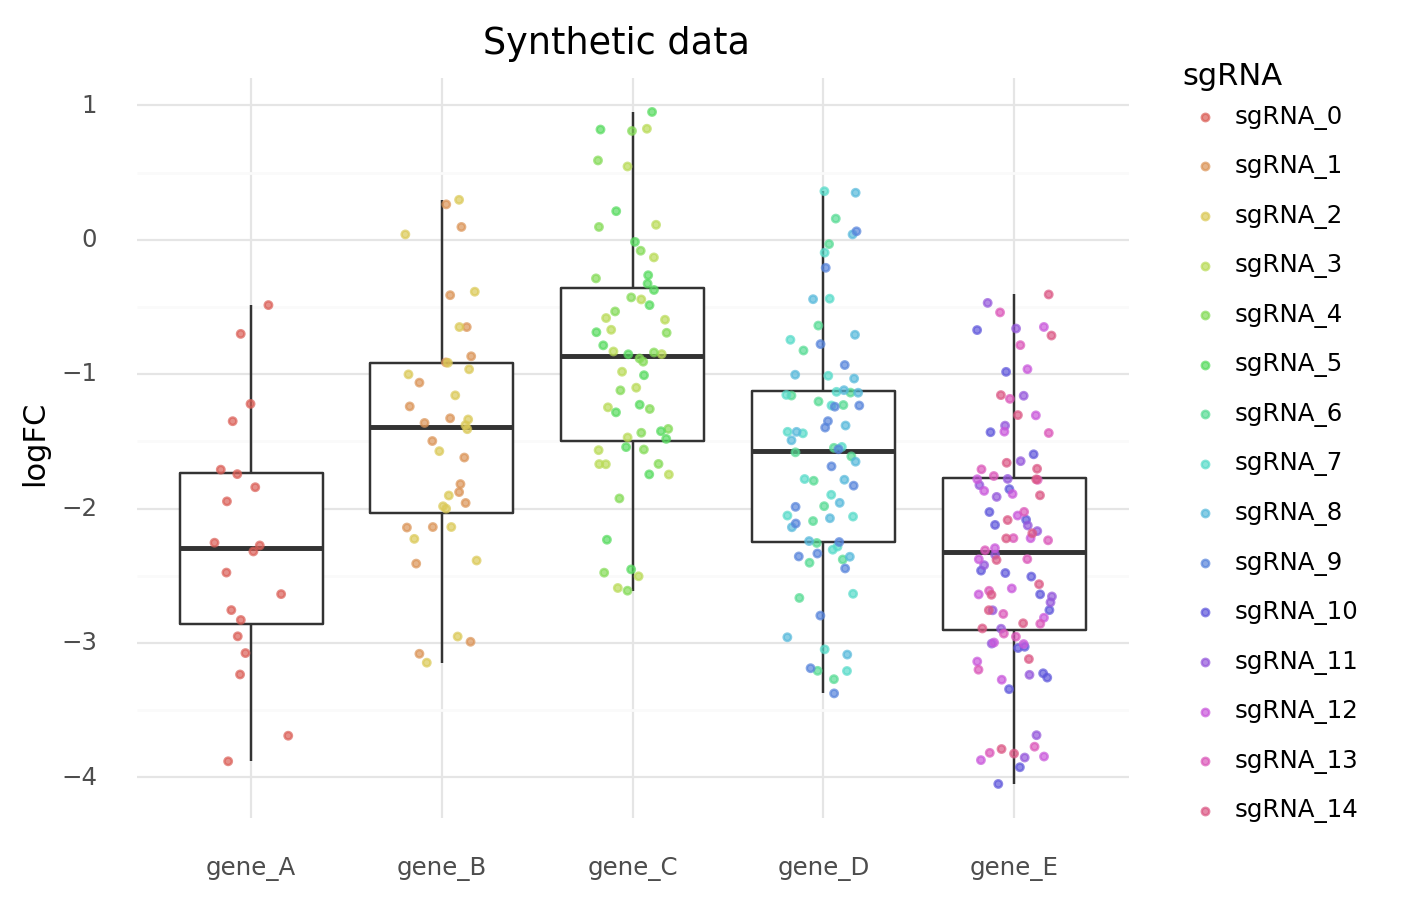

<ggplot: (8777511451862)>

In [4]:
(
    gg.ggplot(data, gg.aes(x="gene", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="sgRNA"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.labs(x="", y="logFC", title="Synthetic data")
)

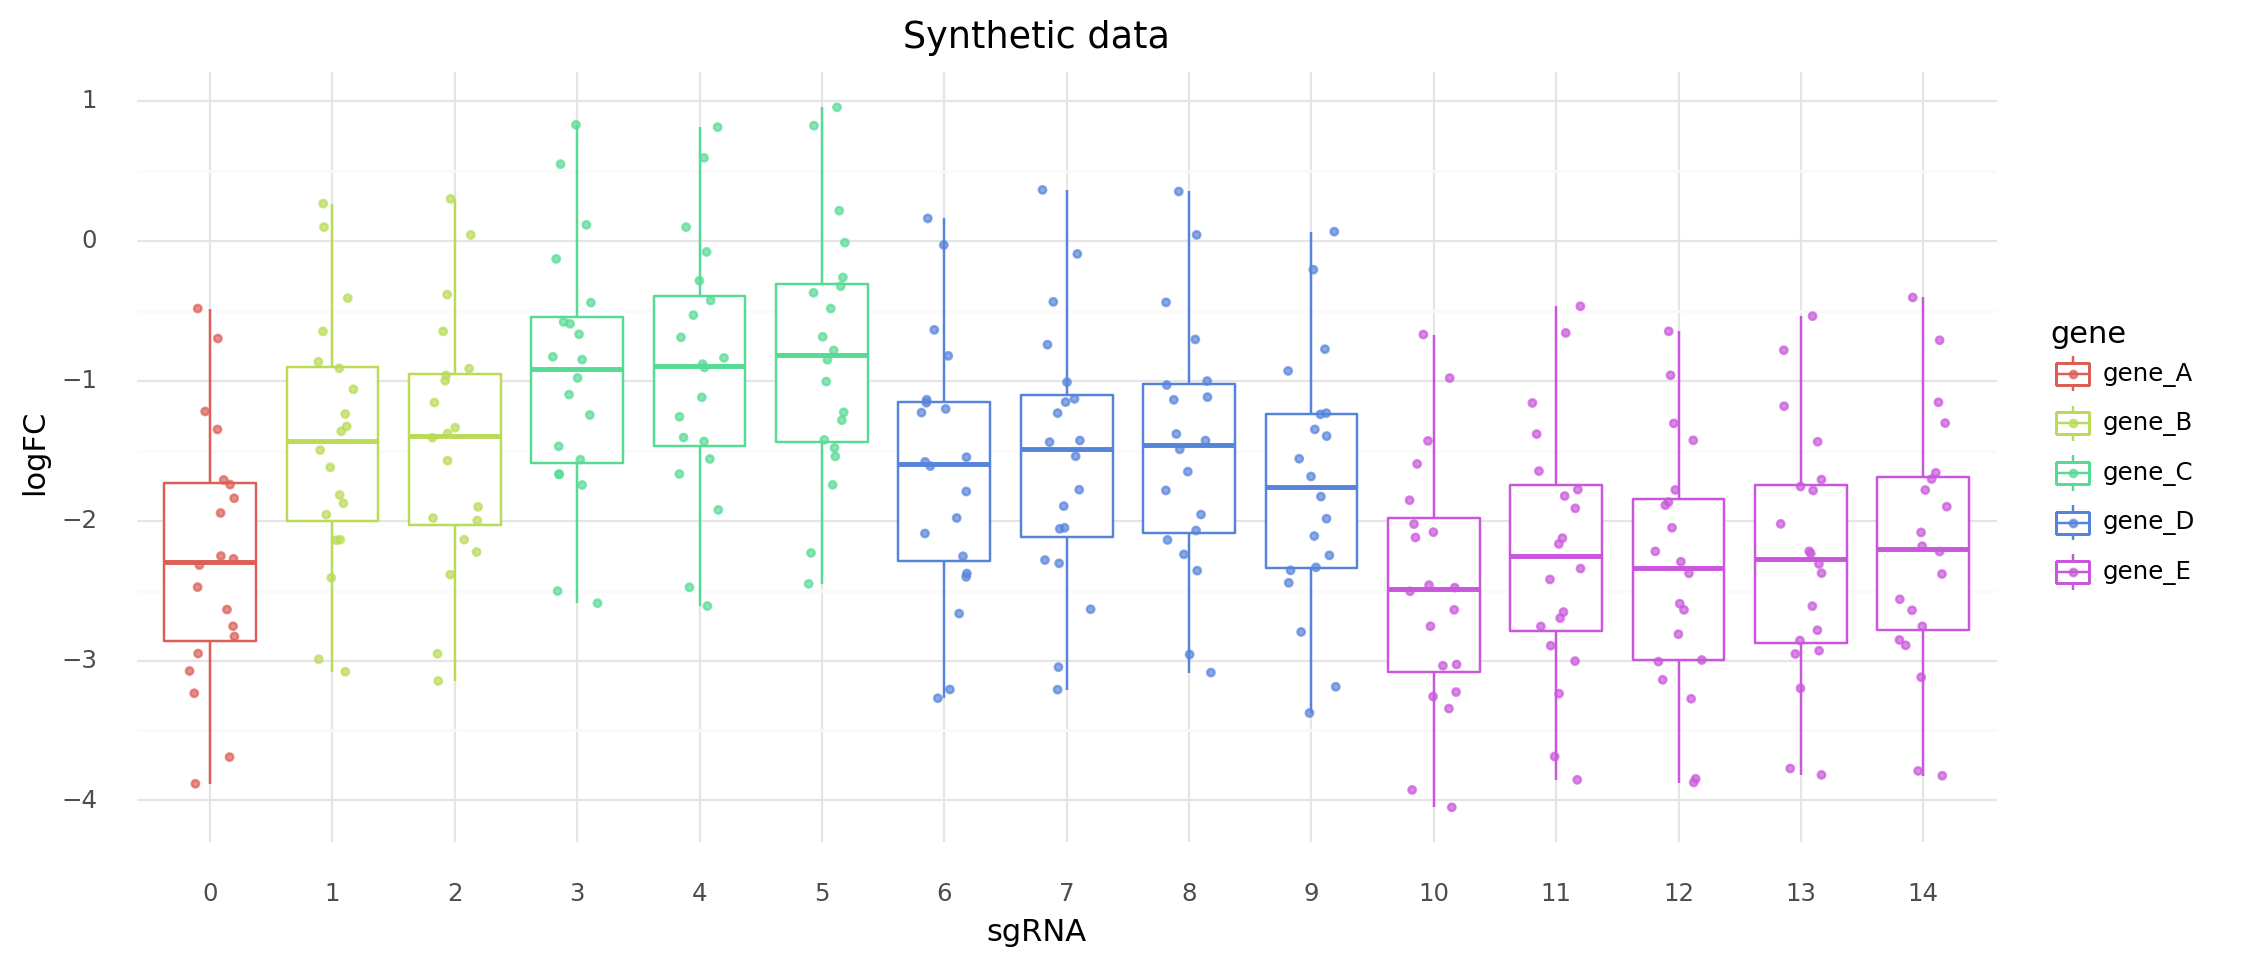

<ggplot: (8777509850338)>

In [5]:
(
    gg.ggplot(data, gg.aes(x="sgRNA", y="logfc"))
    + gg.geom_boxplot(gg.aes(color="gene"), outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.scale_x_discrete(labels=[a.replace("sgRNA_", "") for a in guides])
    + gg.theme(figure_size=(12, 5))
    + gg.labs(x="sgRNA", y="logFC", title="Synthetic data")
)

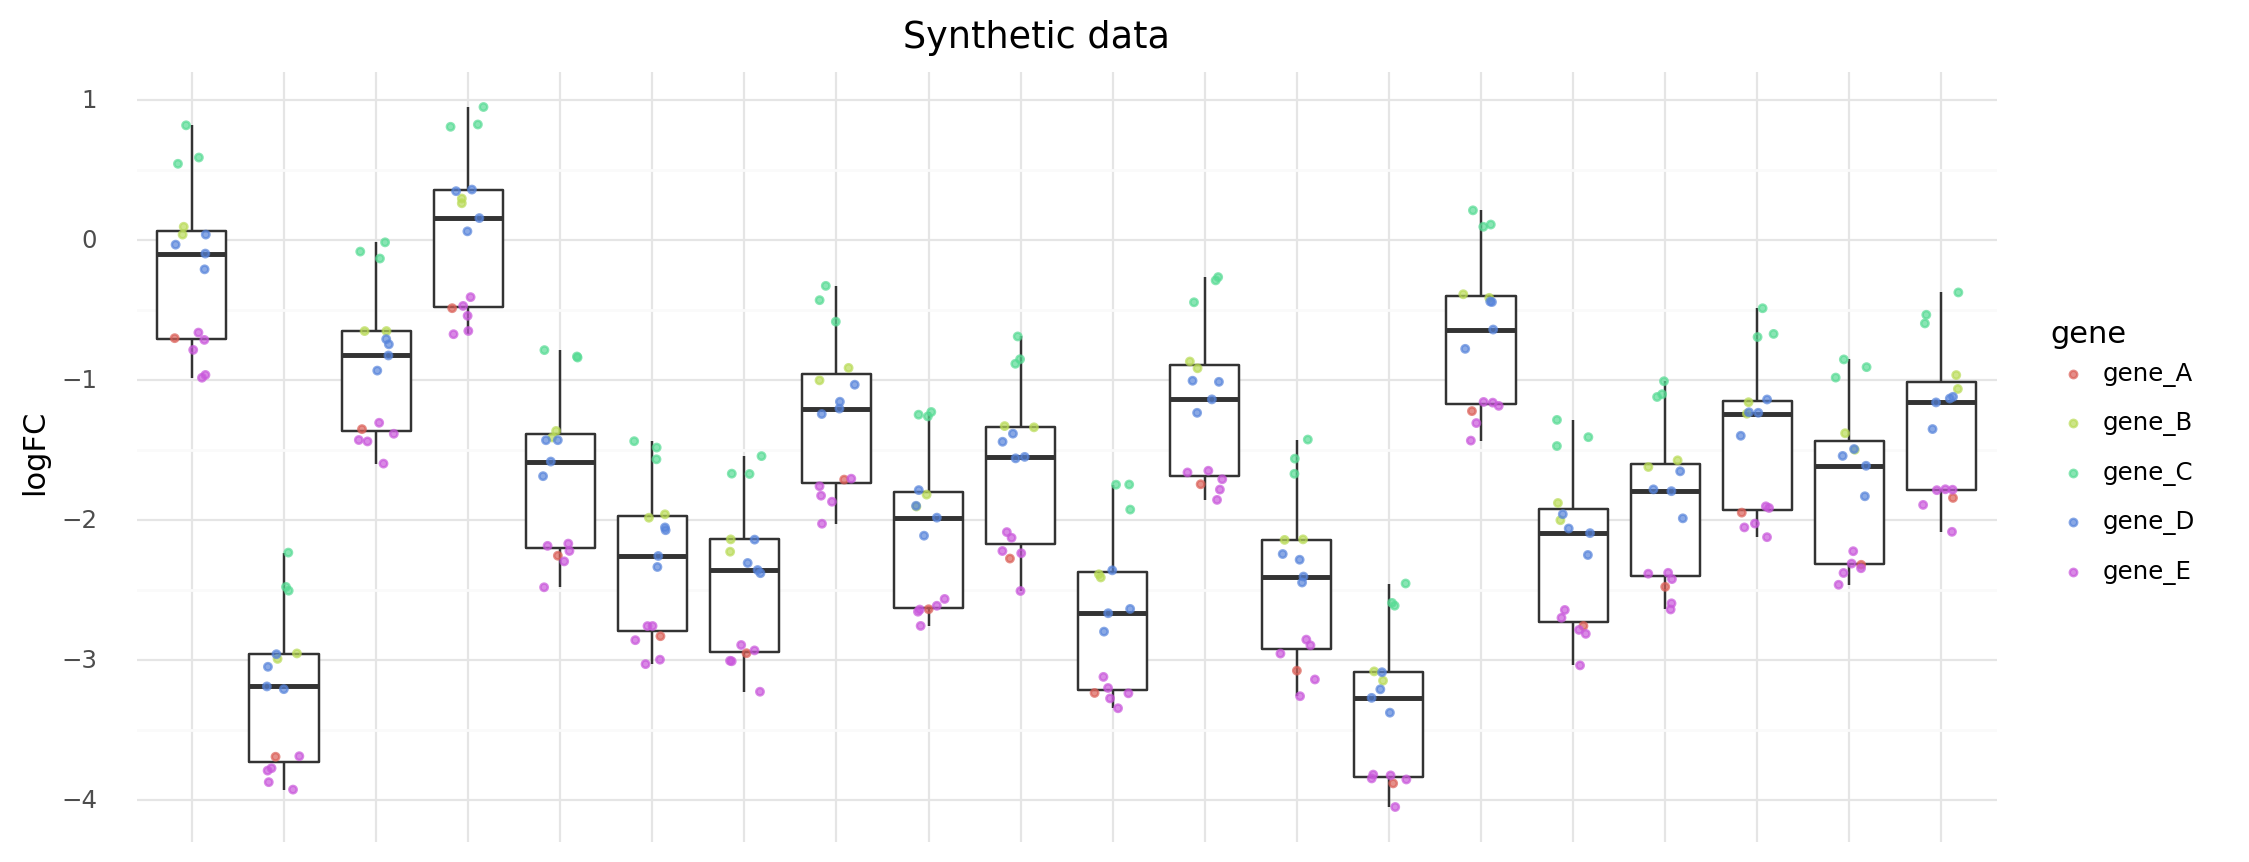

<ggplot: (8777510767083)>

In [6]:
(
    gg.ggplot(data, gg.aes(x="cell_line", y="logfc"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.theme(figure_size=(12, 5), axis_text_x=gg.element_blank())
    + gg.labs(x="", y="logFC", title="Synthetic data")
)

In [7]:
# Data with the cell line effect removed.
rm_cell_line_effect = []
for i in range(len(data)):
    c_idx = data["cell_line"].cat.codes[i]
    c_eff = real_params["beta_c"][c_idx]
    rm_cell_line_effect.append(data["logfc"].values[i] - c_eff)

mod_data = data.copy()
mod_data["logfc_no_cell"] = rm_cell_line_effect

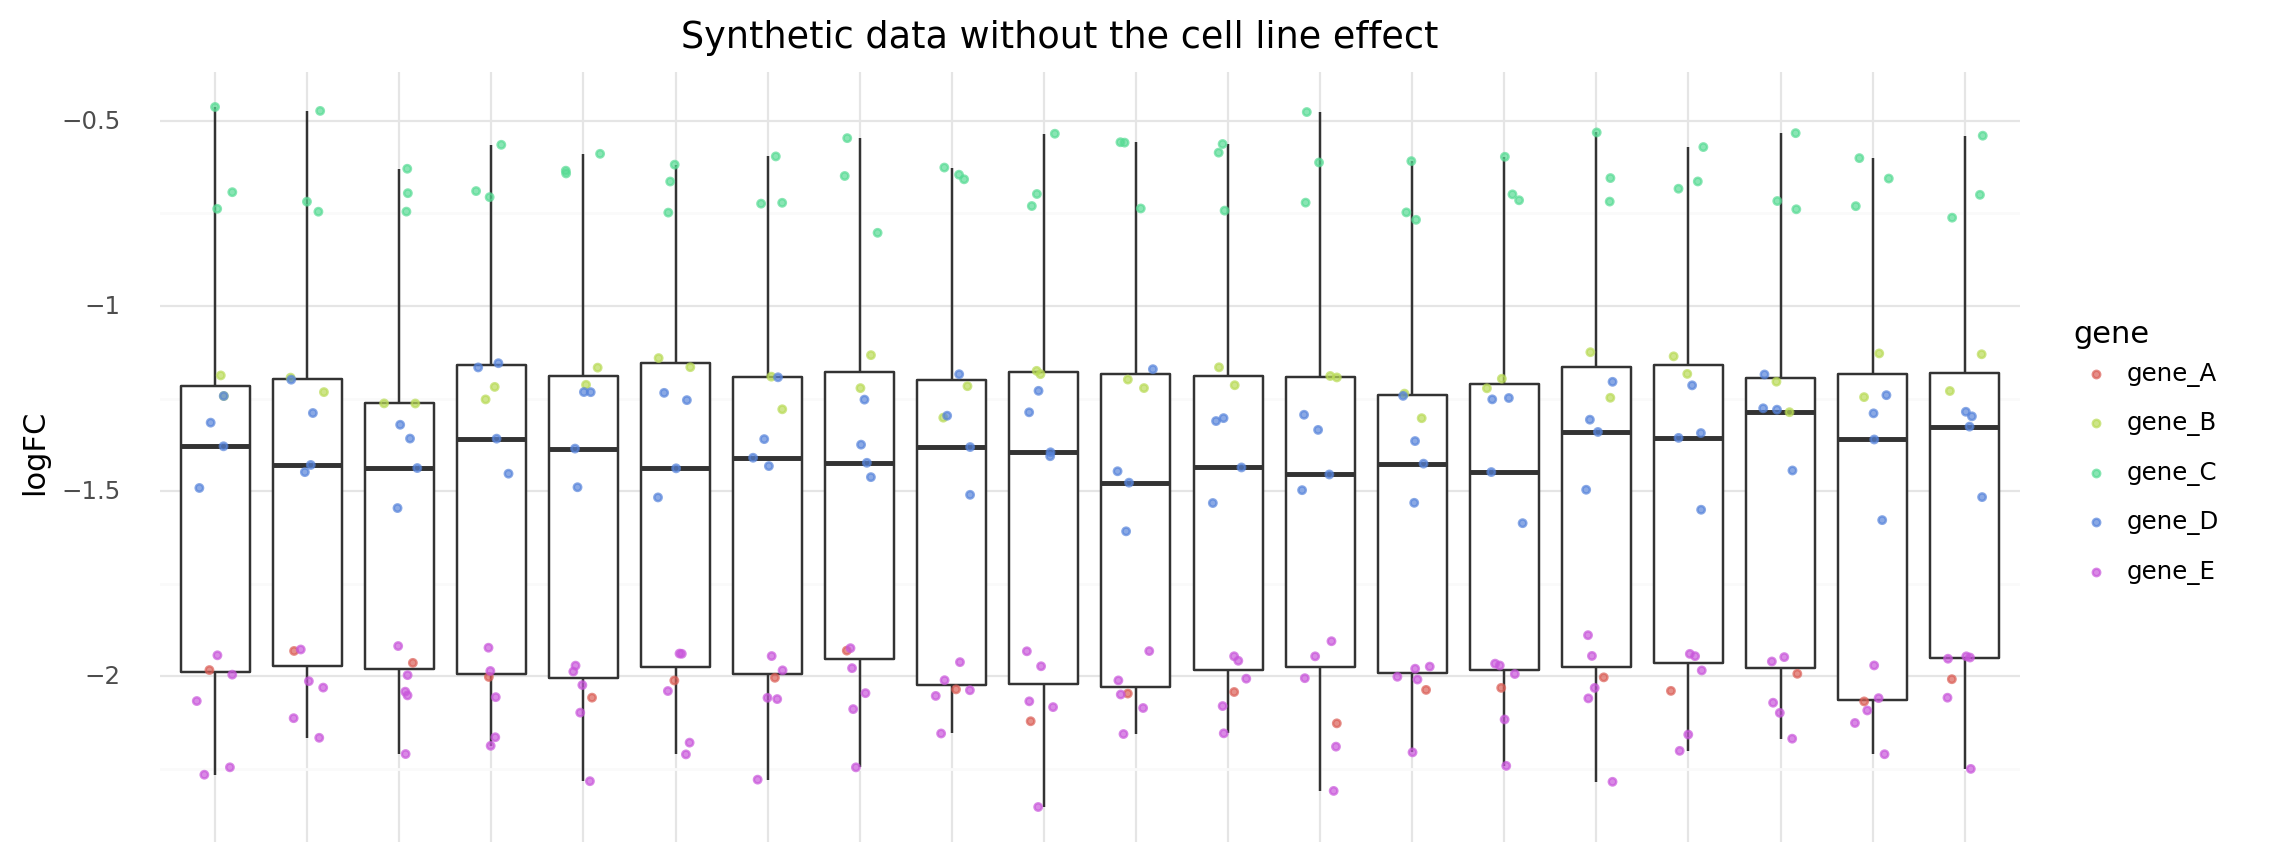

<ggplot: (8777510802071)>

In [8]:
(
    gg.ggplot(mod_data, gg.aes(x="cell_line", y="logfc_no_cell"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="gene"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.theme(figure_size=(12, 5), axis_text_x=gg.element_blank())
    + gg.labs(x="", y="logFC", title="Synthetic data without the cell line effect")
)

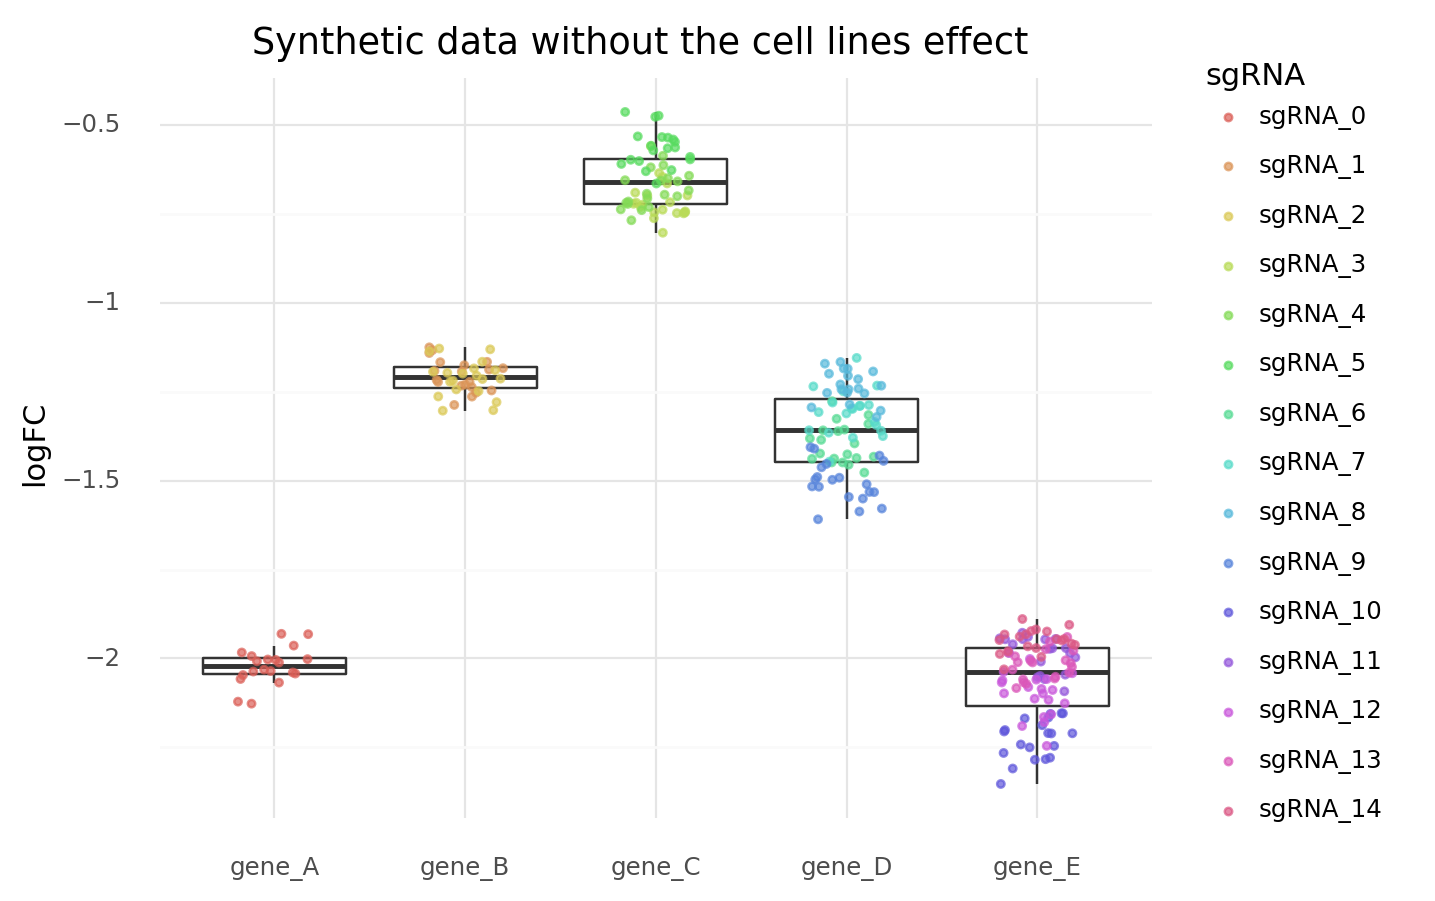

<ggplot: (8777510623407)>

In [9]:
(
    gg.ggplot(mod_data, gg.aes(x="gene", y="logfc_no_cell"))
    + gg.geom_boxplot(outlier_color="")
    + gg.geom_jitter(gg.aes(color="sgRNA"), width=0.2, height=0, size=1, alpha=0.7)
    + gg.scale_color_discrete()
    + gg.labs(x="", y="logFC", title="Synthetic data without the cell lines effect")
)

In [10]:
cell_line_idx = data["cell_line"].cat.codes.to_list()
sgrna_idx = data["sgRNA"].cat.codes.to_list()
sgrna_to_gene_idx = (
    data[["gene", "sgRNA"]].drop_duplicates()["gene"].cat.codes.to_list()
)

with pm.Model() as model5:
    # Gene level model
    mu_epsilon = pm.Normal("mu_epsilon", -1, 5)
    sigma_epsilon = pm.Exponential("sigma_epsilon", 1)
    epsilon_g = pm.Normal("epsilon_g", mu_epsilon, sigma_epsilon, shape=num_genes)

    # Guide level model
    mu_alpha = pm.Deterministic("mu_alpha", epsilon_g[sgrna_to_gene_idx])
    sigma_alpha = pm.Exponential("sigma_alpha", 1)
    alpha_s = pm.Normal("alpha_s", mu_alpha, sigma_alpha, shape=num_sgRNA)

    # Cell line level
    mu_beta = pm.Normal("mu_beta", 0, 3)
    sigma_beta = pm.Exponential("sigma_beta", 1)
    beta_c = pm.Normal("beta_c", mu_beta, sigma_beta, shape=num_cell_lines)

    # Likelihood
    mu_sgc = pm.Deterministic("mu_sgc", alpha_s[sgrna_idx] + beta_c[cell_line_idx])
    sigma = pm.Exponential("sigma", 1)
    logfc = pm.Normal("logfc", mu_sgc, sigma, observed=data["logfc"].values)

    # Sampling
    model5_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model5_trace = pm.sample(4000, tune=1000, random_seed=RANDOM_SEED)
    model5_post_check = pm.sample_posterior_predictive(
        model5_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_c, sigma_beta, mu_beta, alpha_s, sigma_alpha, epsilon_g, sigma_epsilon, mu_epsilon]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 571 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.6787113992161138, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


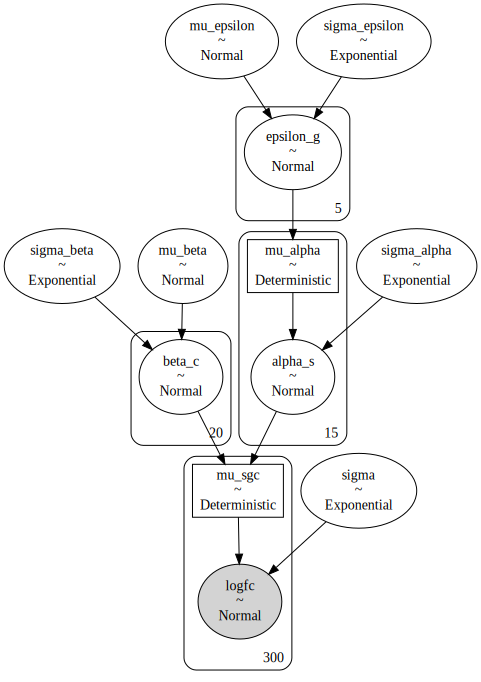

In [11]:
pm.model_to_graphviz(model5)

In [12]:
def plot_variable_prior(prior_check: dict[str, np.ndarray], var: str) -> gg.ggplot:
    prior_df = prior_check[var]
    prior_df = pd.DataFrame(
        prior_df,
        columns=[f"{var}[" + str(i) + "]" for i in range(prior_df.shape[1])],
    ).melt()

    return (
        gg.ggplot(prior_df, gg.aes(x="value"))
        + gg.geom_density(gg.aes(color="variable"))
        + gg.labs(title=f"Prior distribution for '{var}' in model 5")
    )

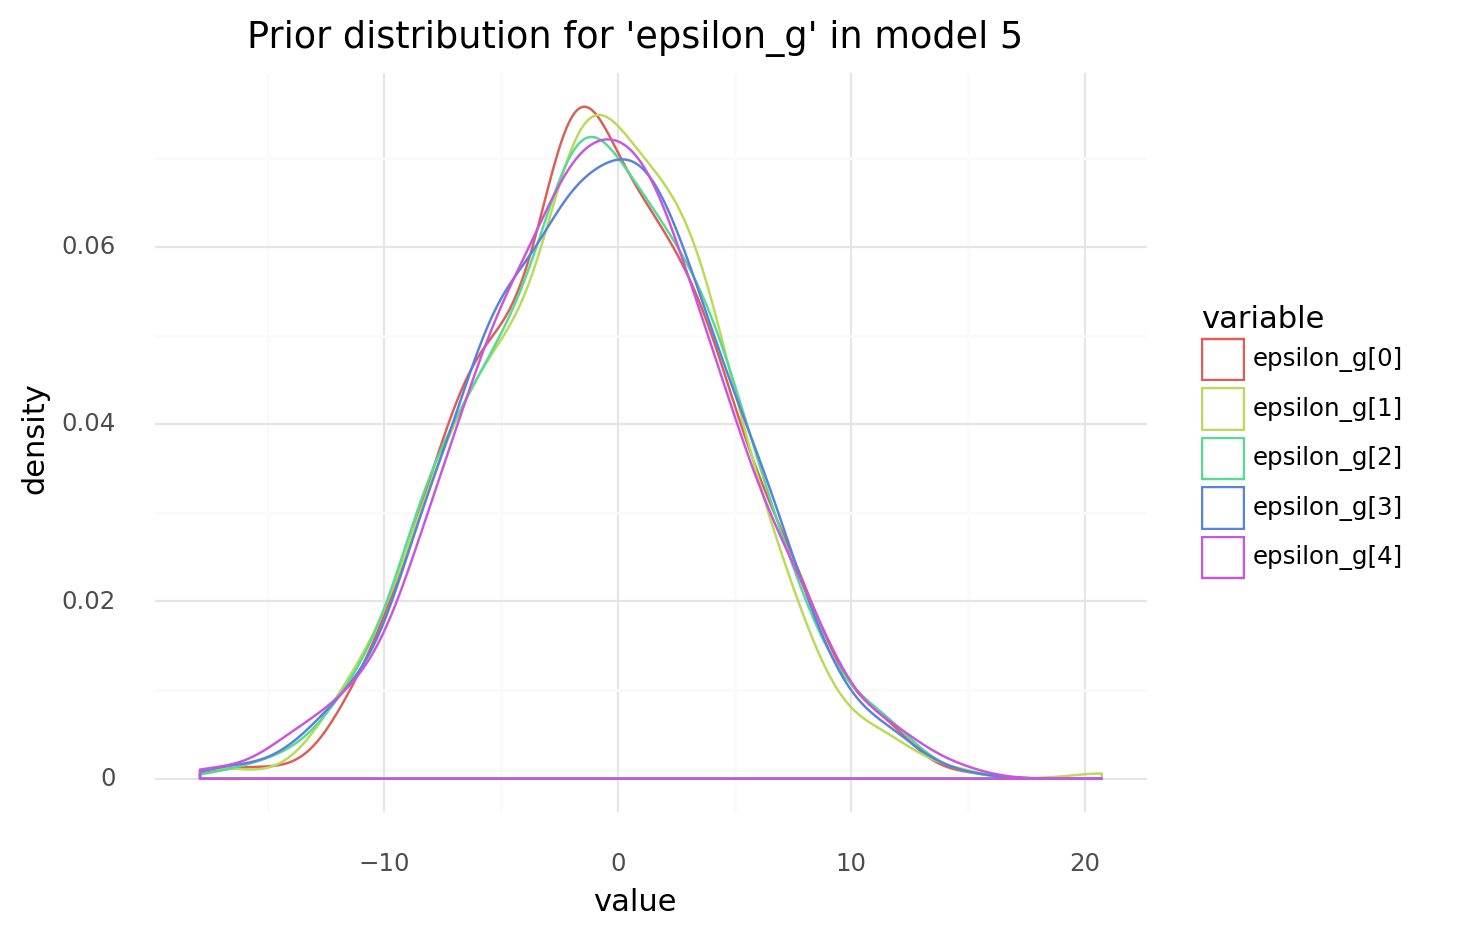

<ggplot: (8777510742203)>

In [13]:
plot_variable_prior(model5_prior_check, "epsilon_g")

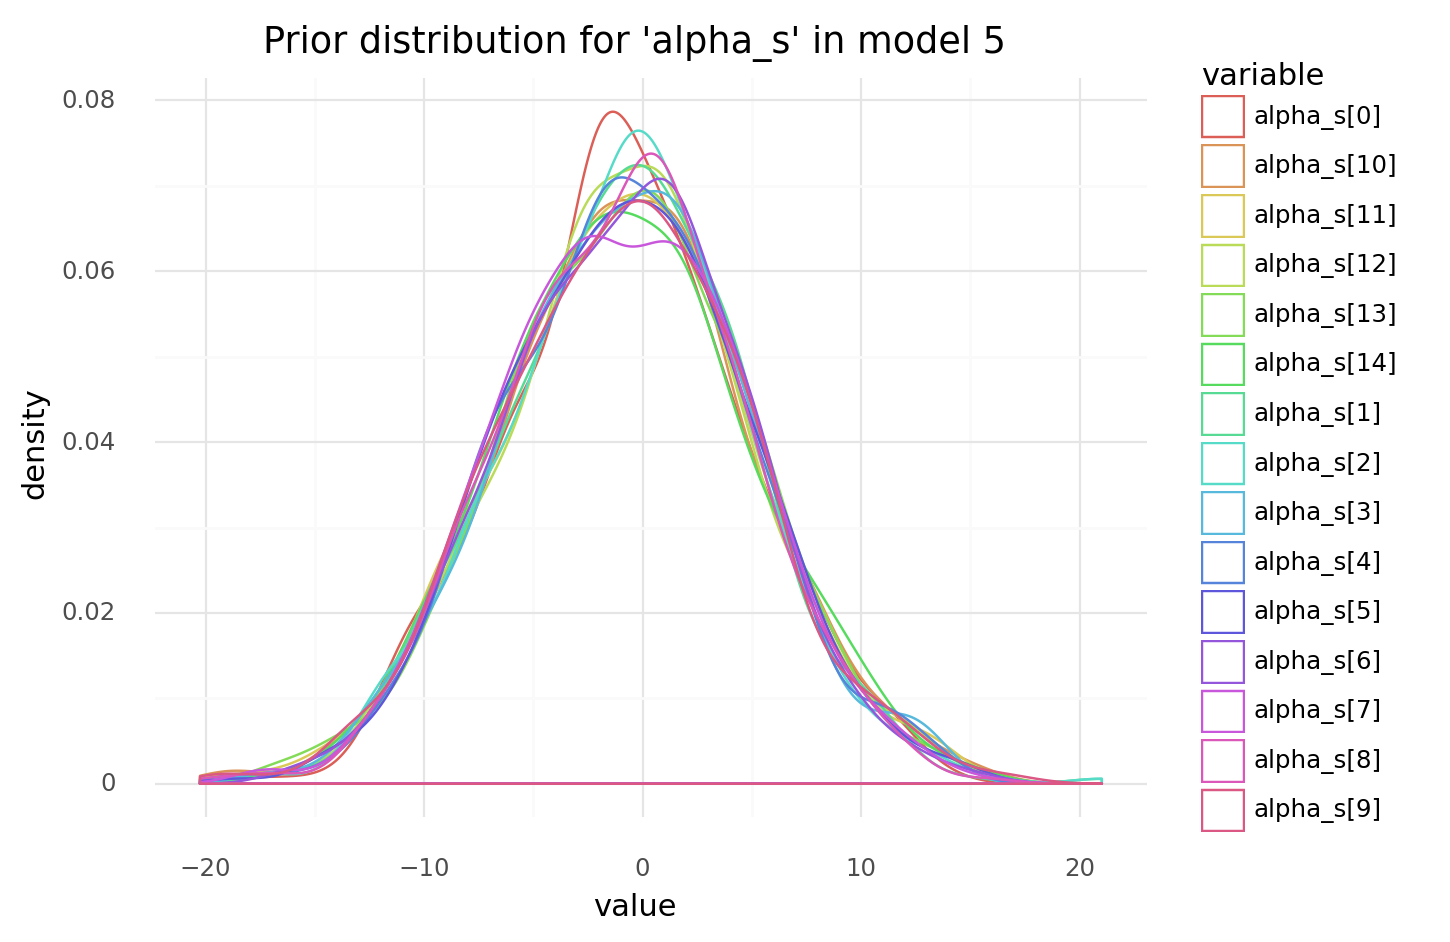

<ggplot: (8777510638517)>

In [14]:
plot_variable_prior(model5_prior_check, "alpha_s")

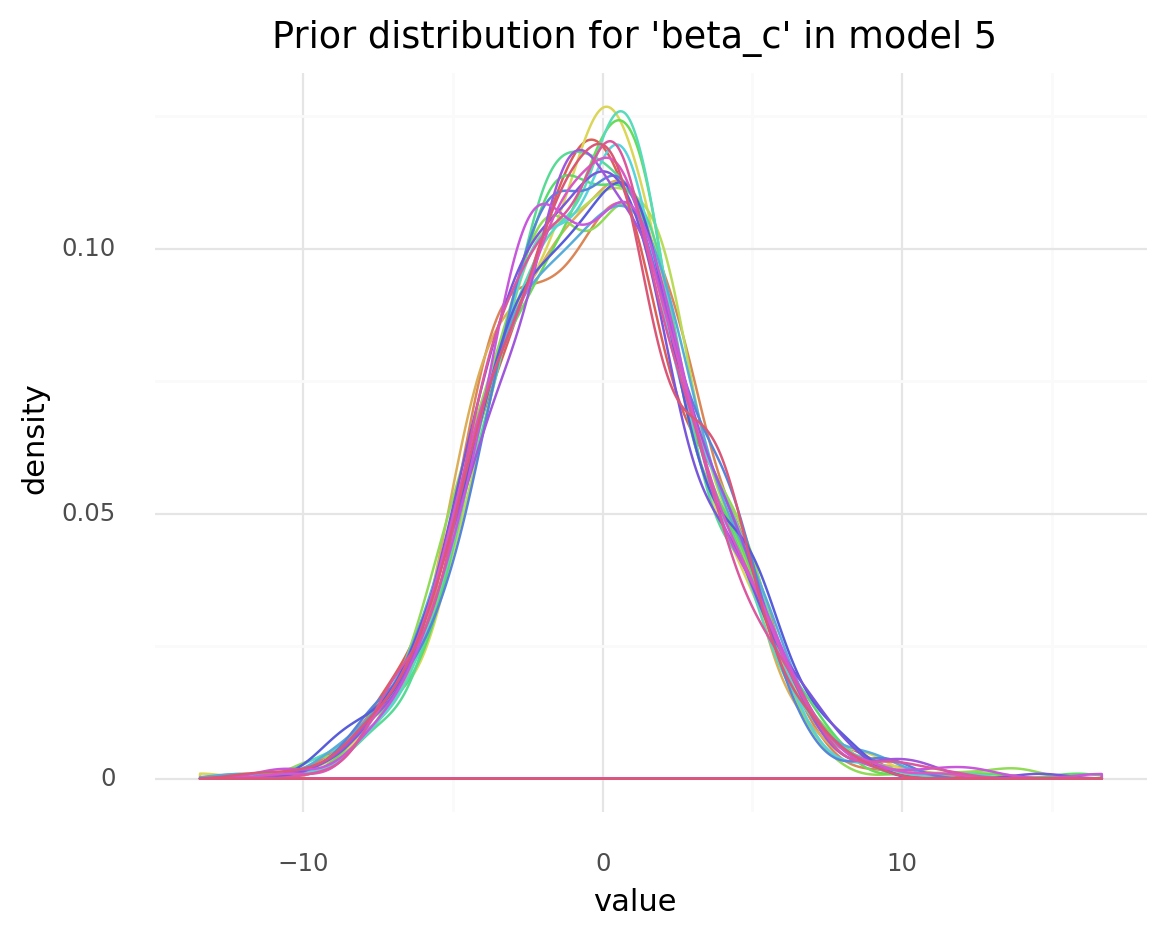

<ggplot: (8777510802071)>

In [15]:
plot_variable_prior(model5_prior_check, "beta_c") + gg.theme(legend_position="none")

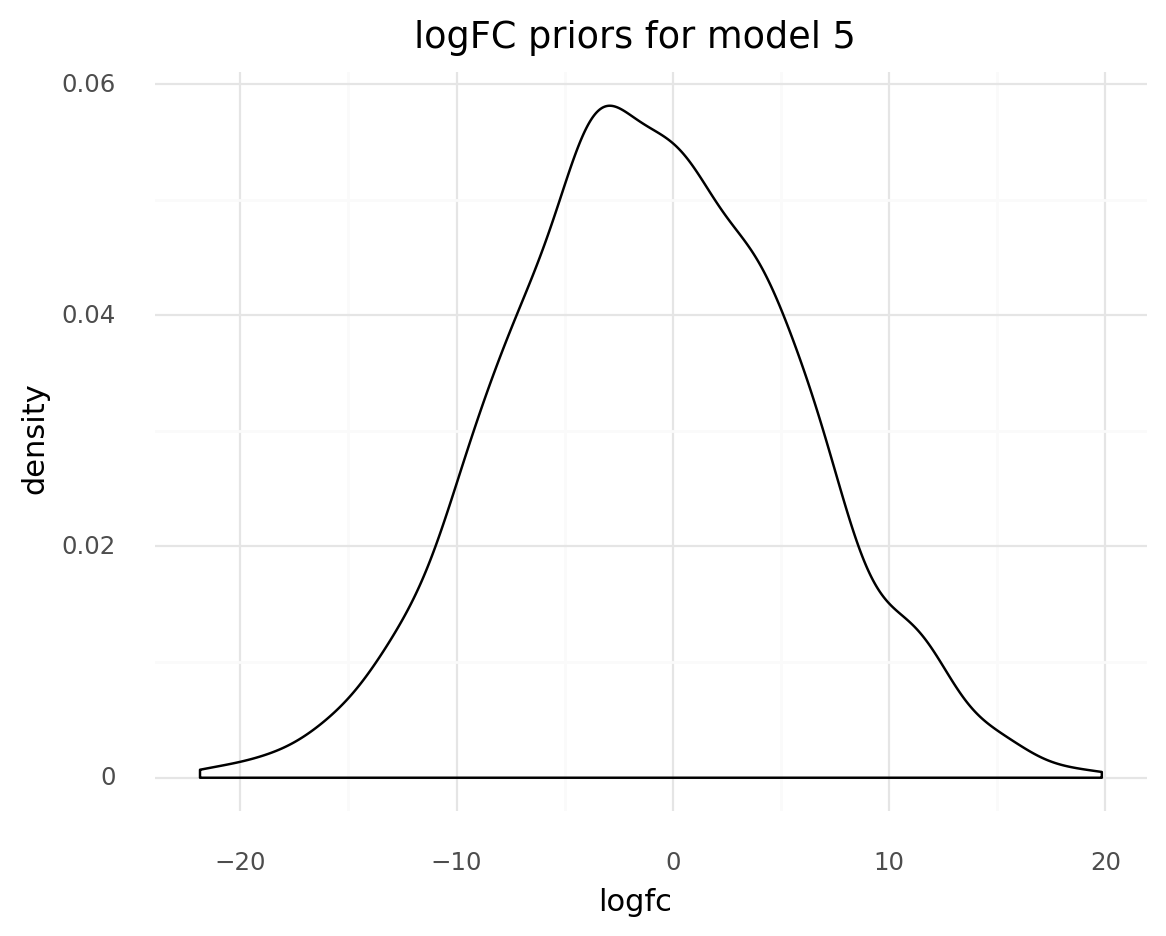

<ggplot: (8777510638583)>

In [16]:
logfc_priors = pd.DataFrame({"logfc": model5_prior_check["logfc"].flatten()[::100]})

(
    gg.ggplot(logfc_priors, gg.aes(x="logfc"))
    + gg.geom_density()
    + gg.labs(title="logFC priors for model 5")
)

In [17]:
az_model5 = az.from_pymc3(
    trace=model5_trace,
    prior=model5_prior_check,
    posterior_predictive=model5_post_check,
    model=model5,
)

In [18]:
az.summary(az_model5, var_names=["mu_epsilon"]).assign(
    real_values=real_params["mu_epsilon"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
mu_epsilon,-1.442,2.671,-6.42,3.645,0.16,0.114,277.0,277.0,286.0,372.0,1.01,-1


In [19]:
az.summary(az_model5, var_names=["epsilon_g"]).assign(
    real_values=real_params["epsilon_g"]
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,real_values
epsilon_g[0],-1.993,2.661,-6.869,3.226,0.161,0.114,273.0,273.0,282.0,370.0,1.01,-2.249278
epsilon_g[1],-1.206,2.659,-6.155,3.919,0.161,0.114,272.0,272.0,282.0,368.0,1.01,-1.260331
epsilon_g[2],-0.657,2.660,-5.531,4.546,0.161,0.114,273.0,273.0,282.0,374.0,1.01,-0.616207
epsilon_g[3],-1.354,2.659,-6.259,3.812,0.161,0.114,273.0,273.0,282.0,373.0,1.01,-1.385461
epsilon_g[4],-2.045,2.659,-7.043,3.038,0.161,0.114,272.0,272.0,281.0,369.0,1.01,-2.085137


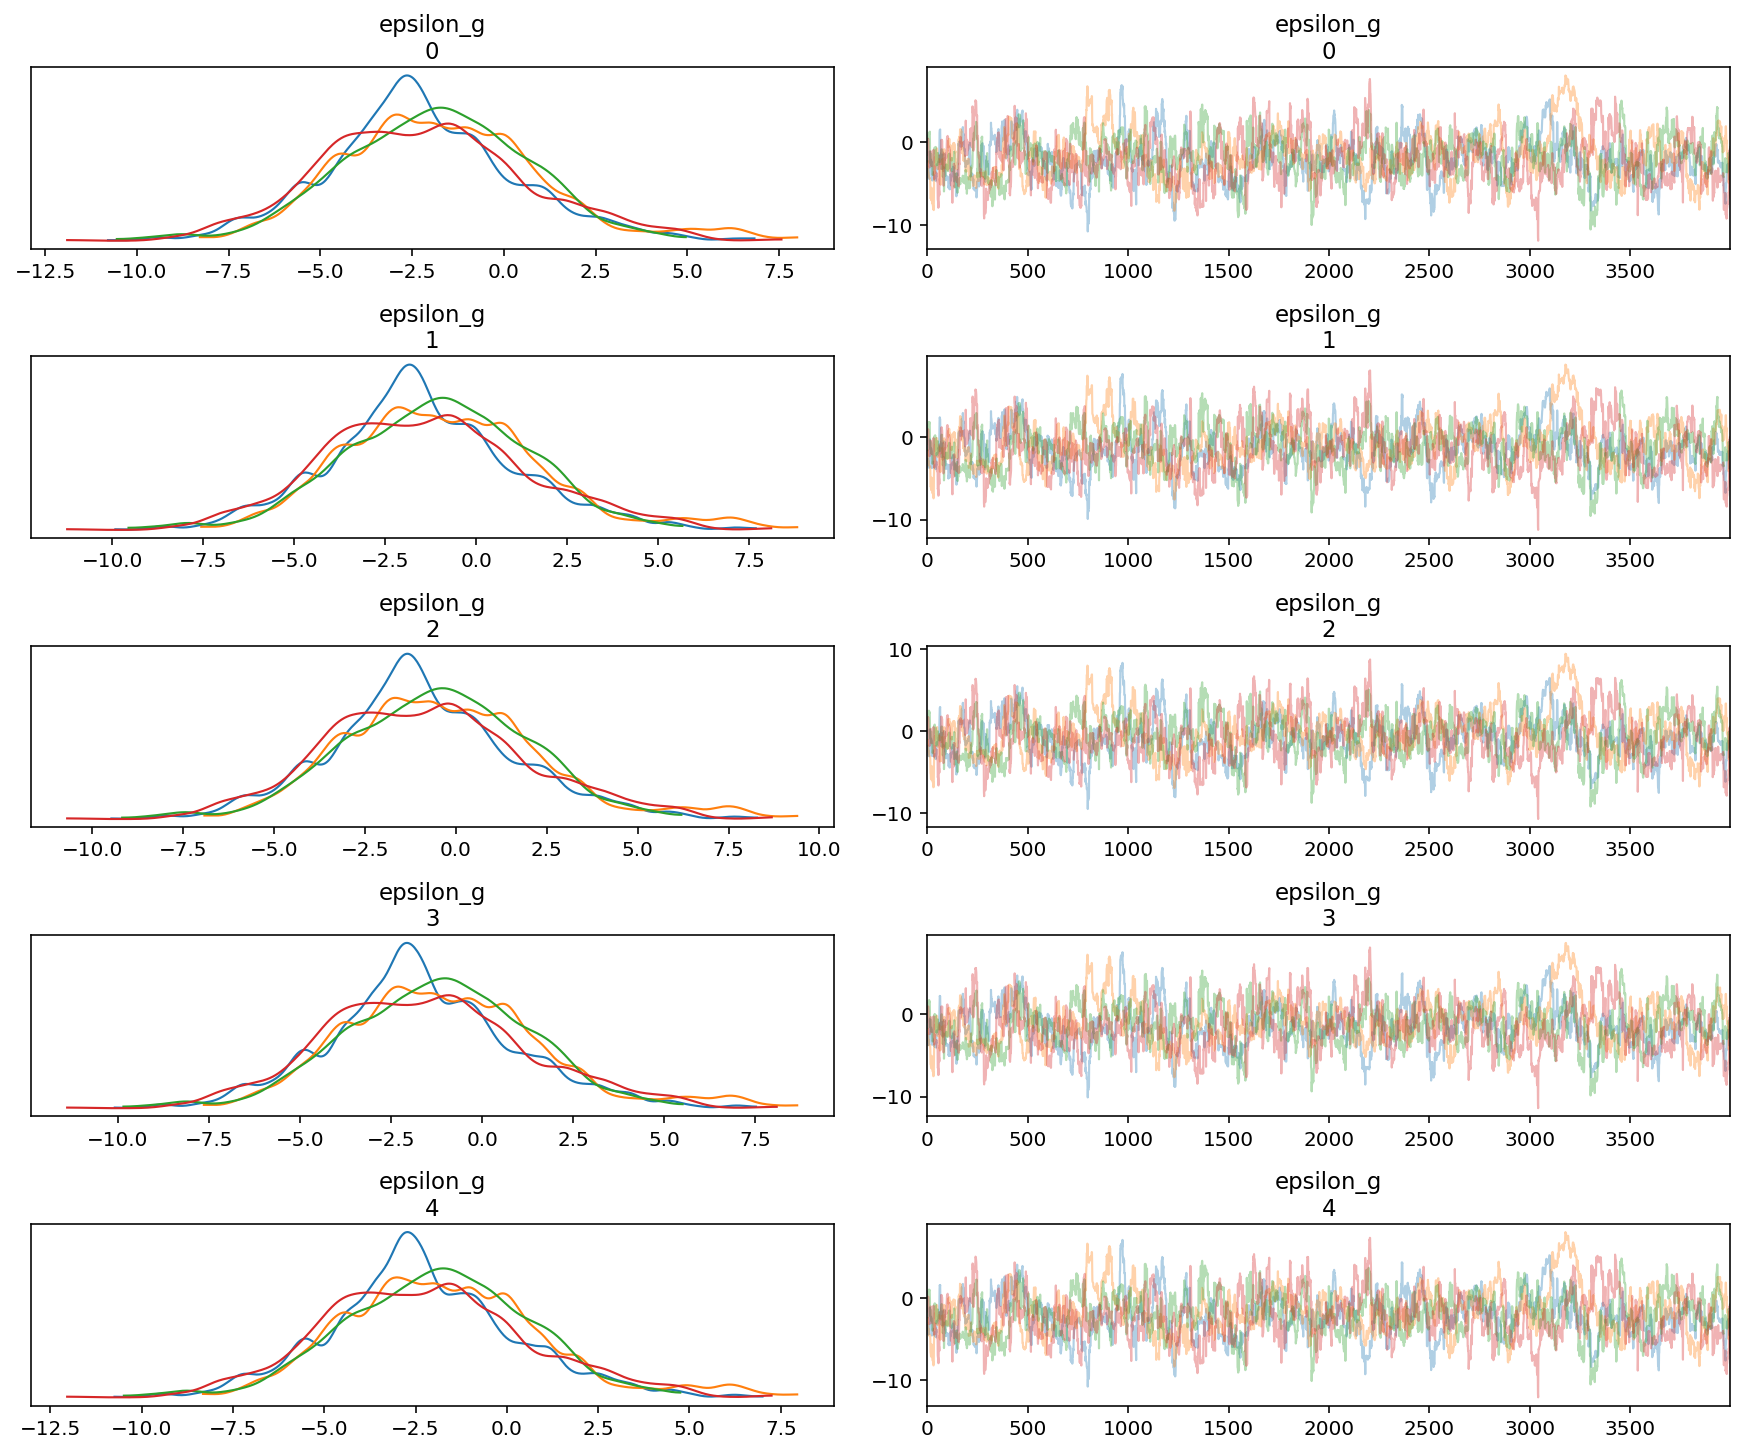

In [20]:
az.plot_trace(az_model5, var_names=["epsilon_g"])
plt.show()

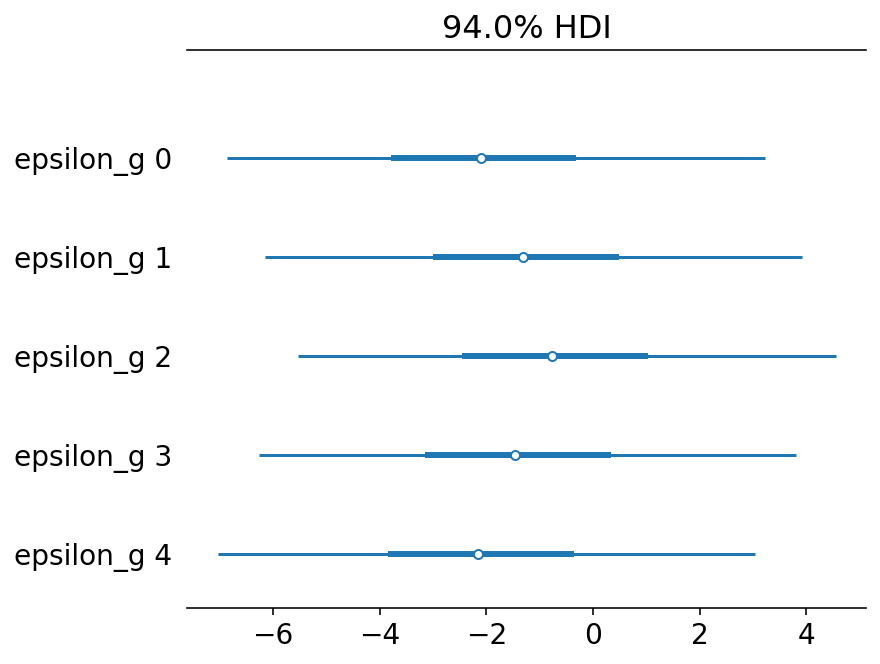

In [21]:
az.plot_forest(az_model5, var_names=["epsilon_g"], combined=True)
plt.show()

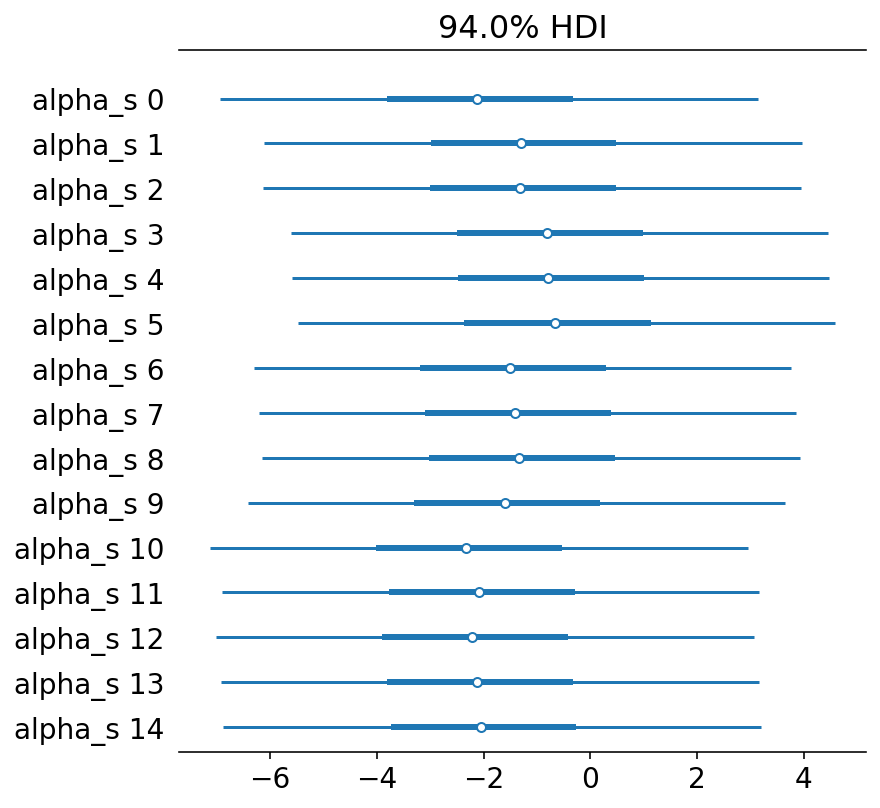

In [22]:
az.plot_forest(az_model5, var_names=["alpha_s"], combined=True)
plt.show()

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

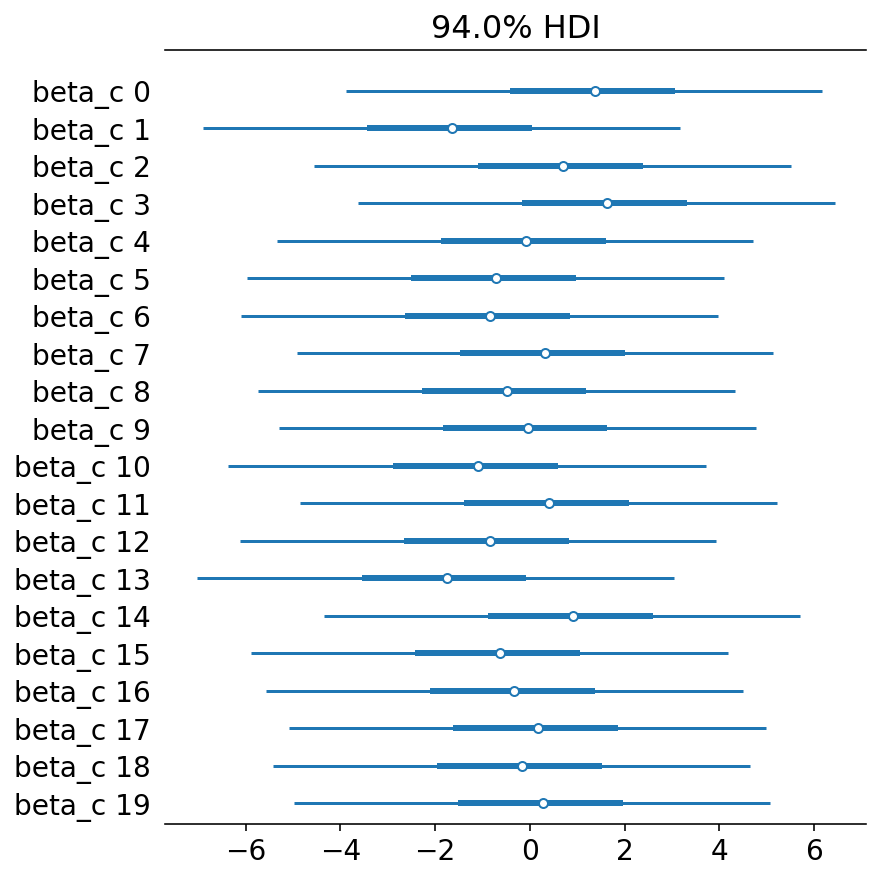

In [23]:
az.plot_forest(az_model5, var_names="beta_c", combined=True)

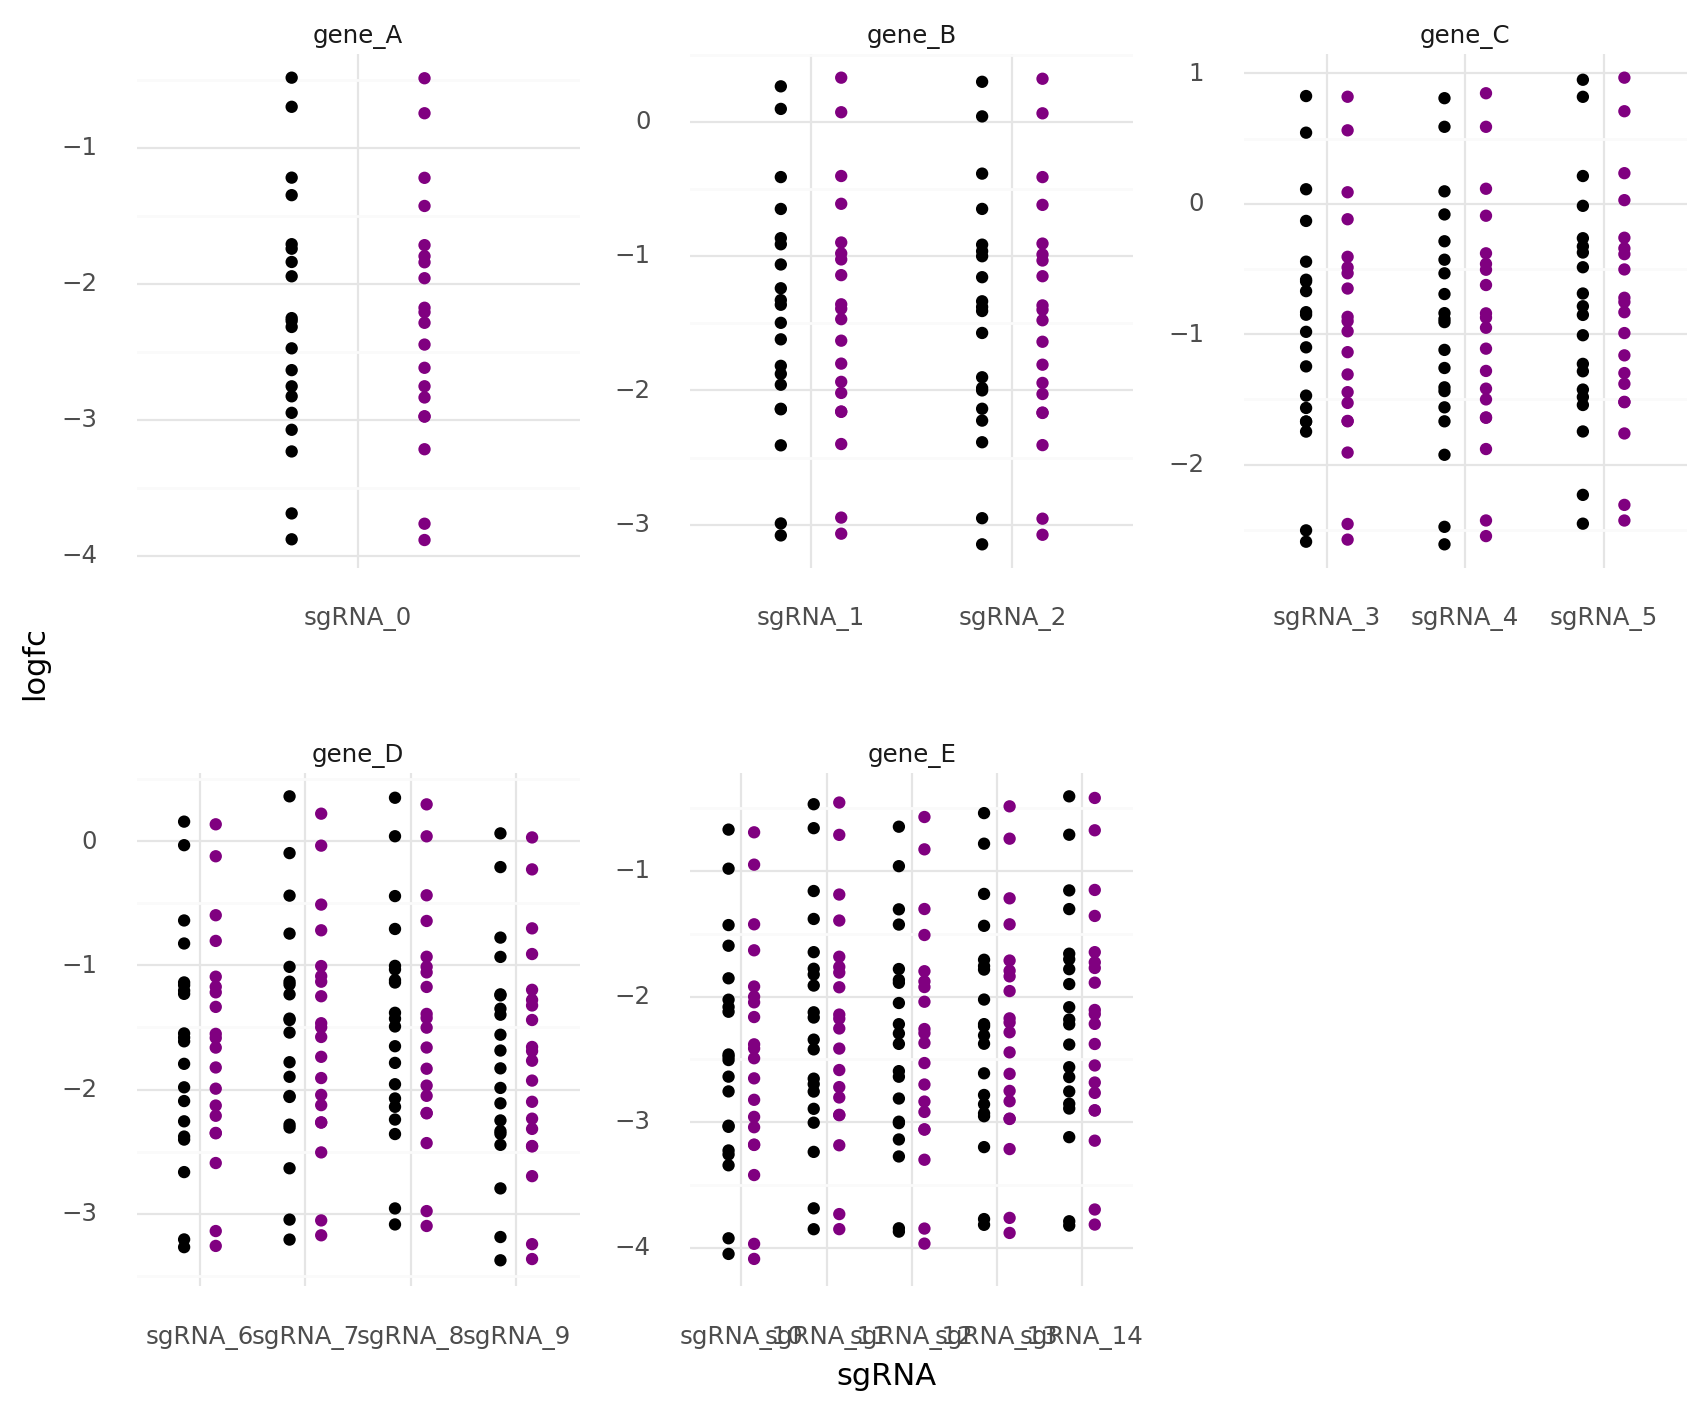

<ggplot: (8777502303817)>

In [24]:
model5_mu_post = model5_trace.get_values("mu_sgc")
model5_mu_mean = model5_mu_post.mean(axis=0)
model5_mu_hdi = [az.hpd(x, credible_interval=0.89) for x in model5_mu_post.T]

model5_ppc = data.copy()
model5_ppc["mu_mean"] = model5_mu_mean
model5_ppc["lower_ci"] = [x[0] for x in model5_mu_hdi]
model5_ppc["upper_ci"] = [x[1] for x in model5_mu_hdi]

pos_shift = 0.15

(
    gg.ggplot(model5_ppc, gg.aes("sgRNA"))
    + gg.facet_wrap("gene", scales="free")
    + gg.geom_point(gg.aes(y="logfc"), position=gg.position_nudge(x=-pos_shift))
    + gg.geom_point(
        gg.aes(y="mu_mean"), position=gg.position_nudge(x=pos_shift), color="purple"
    )
    + gg.geom_linerange(
        gg.aes(ymin="lower_ci", ymax="lower_ci"),
        position=gg.position_nudge(x=pos_shift),
        color="purple",
    )
    + gg.theme(subplots_adjust={"hspace": 0.4, "wspace": 0.25}, figure_size=(10, 8))
)

### Conclusions and final thoughts

The model fits well, as shown by the very tight posterior predictions of each data point.
Reassuringly, there is also visible shrinkage in the predictions.

The posterior distributions of the parameters of $\alpha_s$, $\epsilon_g$, and $\beta_c$ are *very* wide, though the mean/MAP values are very accurate.
To me, this suggests that there is a lot of correlation between the posterior values. 
This would lead to greater play in the posteriors while maintaining very high accuracy in posterior predictions.

This is proven with the following plot. 🤦🏻‍♂️

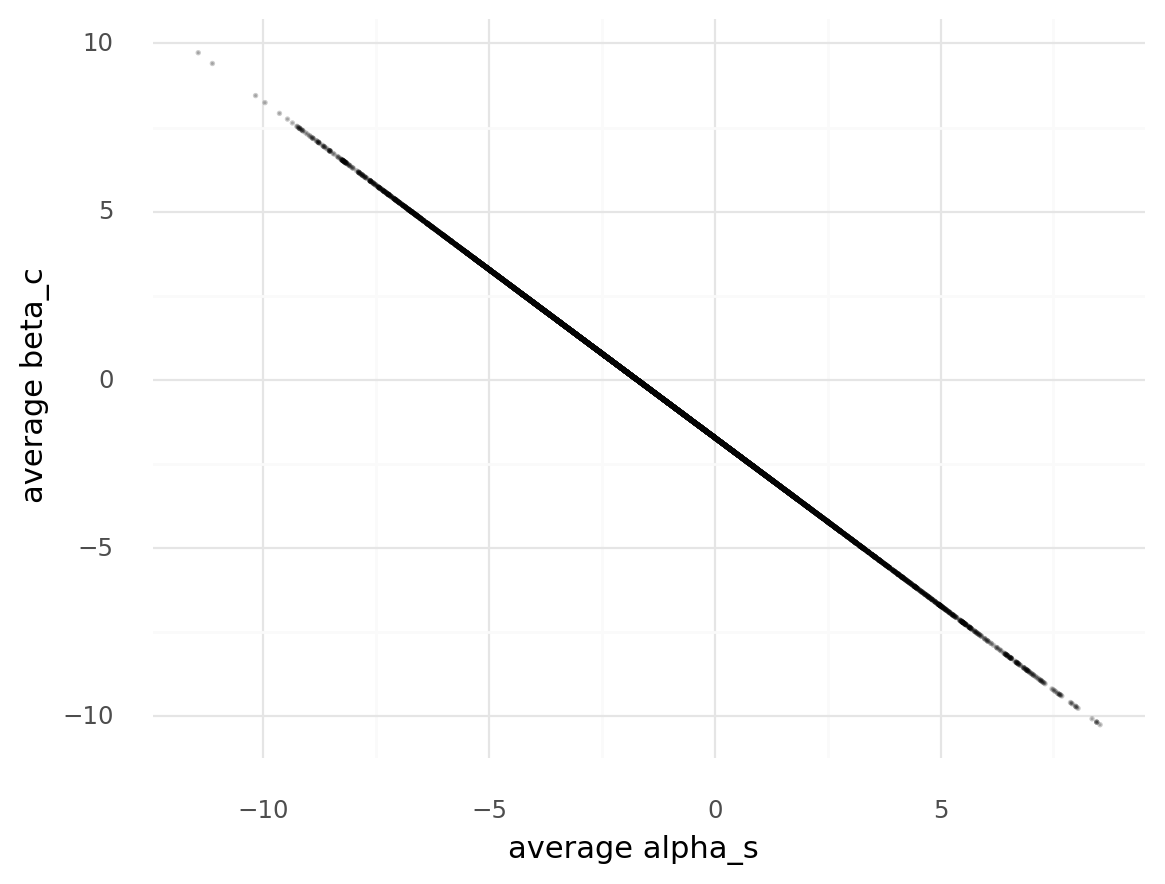

<ggplot: (8777502293324)>

In [25]:
d = pd.DataFrame(
    {
        "alpha_s": model5_trace.get_values("alpha_s").mean(axis=1),
        "beta_c": model5_trace.get_values("beta_c").mean(axis=1),
    }
)

(
    gg.ggplot(d, gg.aes("alpha_s", "beta_c"))
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="average alpha_s", y="average beta_c")
)

---

In [26]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 10.67 minutes


In [27]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

seaborn  0.11.0
numpy    1.19.2
plotnine 0.7.1
pymc3    3.9.3
arviz    0.10.0
pandas   1.1.3
last updated: 2020-12-17 

CPython 3.8.5
IPython 7.18.1

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-1062.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 32
interpreter: 64bit
host name  : compute-a-16-78.o2.rc.hms.harvard.edu
Git branch : subset-data
